In [93]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, text, MetaData
from sqlalchemy.exc import IntegrityError
import numpy as np

In [94]:
engine = create_engine('postgresql:///piwheels')
conn = engine.connect()
meta = MetaData()
meta.bind = conn
meta.reflect(views=True)

In [ ]:
downloads_by_year = pd.read_sql(f"""
    SELECT date_trunc('year', accessed_at) y, COUNT(*) AS c
    FROM downloads
    WHERE accessed_at > '2000-01-01'
    GROUP BY y
    ORDER BY y
""", conn)

downloads_by_year

In [ ]:
plt.rcParams["figure.figsize"] = (10, 6)

years = [y.year for y in downloads_by_year['y']]

plt.bar(range(len(downloads_by_year)), downloads_by_year['c'])
plt.title('Downloads by year')
plt.xticks(range(len(downloads_by_year)), years)

plt.savefig('downloads-by-year.png')

plt.show()

In [ ]:
downloads_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) m, COUNT(*) AS c
    FROM downloads
    WHERE accessed_at > '2000-01-01'
    GROUP BY m
    ORDER BY m
""", conn)

In [ ]:
plt.rcParams["figure.figsize"] = (16, 6)

months = [m.month_name()[:1] for m in downloads_by_month['m']]
downloads = [c for c in downloads_by_month['c']]

plt.bar(range(len(months)), downloads)
plt.title('Downloads by month')
plt.xticks(range(len(months)), months)

plt.savefig('downloads-by-month.png')

plt.show()

In [7]:
def get_py_minor_ver(ver):
    parts = ver.split('.')
    return '.'.join(parts[:2])

In [66]:
from collections import defaultdict

def group_by_py_minor_ver(py_vers):
    versions = defaultdict(int)
    for index, row in py_vers.iterrows():
        v = get_py_minor_ver(row['pyver'])
        versions[v] += row['c']
    return versions

In [65]:
def get_python_versions_from_searches(year, month):
    if month < 10:
        month = f'0{month}'
    results = pd.read_sql(f"""
        SELECT py_version pyver, count(*) c
        FROM searches
        WHERE date_trunc('month', accessed_at) = '{year}-{month}-01'
        AND os_name = 'Linux'
        AND distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
        AND py_name = 'CPython'
        GROUP BY pyver
    """, conn)
    return group_by_py_minor_ver(results)

In [90]:
def get_python_versions_from_downloads(year, month):
    if month < 10:
        month = f'0{month}'
    results = pd.read_sql(f"""
        SELECT py_version pyver, count(*) c
        FROM downloads
        WHERE date_trunc('month', accessed_at) = '{year}-{month}-01'
        AND os_name = 'Linux'
        AND distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
        AND py_name = 'CPython'
        GROUP BY pyver
    """, conn)
    return group_by_py_minor_ver(results)

In [71]:
months = (
    [(2019, m) for m in range(6, 13)] +
    [(2020, m) for m in range(1, 13)] +
    [(2021, m) for m in range(1, 11)]
)

In [23]:
py_vers = [((year, month), get_python_versions_from_searches(year, month)) for year, month in months]

In [101]:
months = (
    [(2017, 12)] +
    [(2018, m) for m in range(1, 13)] +
    [(2019, m) for m in range(1, 13)] +
    [(2020, m) for m in range(1, 13)] +
    [(2021, m) for m in range(1, 11)]
)

py_vers_dl = [((year, month), get_python_versions_from_downloads(year, month)) for year, month in months]

In [34]:
import json

with open('py_vers2.json', 'w') as f:
    json.dump(py_vers, f)

In [102]:
data = {
    '2.7': [],
    '3.4': [],
    '3.5': [],
    '3.7': [],
    '3.9': [],
}
for ym, vers in py_vers_dl:
    total = sum(vers[v] for v in data)
    for v in data:
        data[v].append(round(100*vers[v] / total, 2))

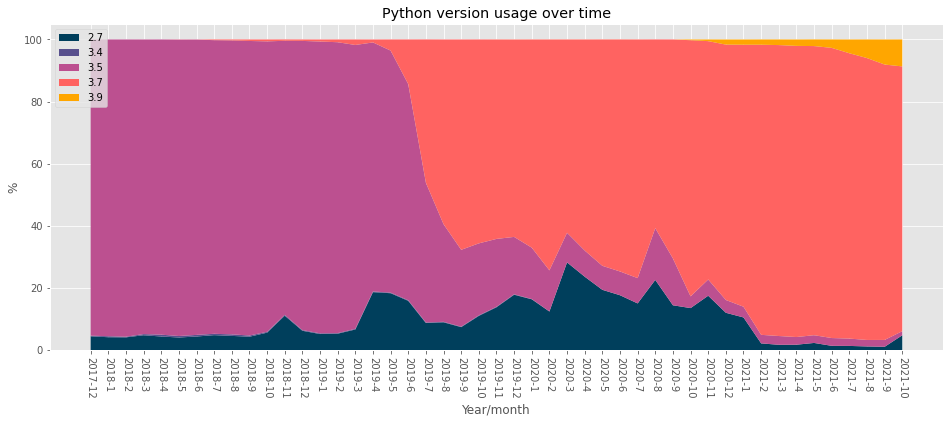

In [107]:
plt.rcParams["figure.figsize"] = (16, 6)

colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

fig, ax = plt.subplots()
ax.stackplot([f'{y}-{m}' for y, m in months], data.values(), labels=data.keys(), colors=colors)
plt.xticks(rotation=-90)
ax.legend(loc='upper left')
ax.set_title('Python version usage over time')
ax.set_xlabel('Year/month')
ax.set_ylabel('%')
plt.savefig('pyvers-time.png')
plt.show()